In [63]:
import numpy as np # thư viện tính toán số học
import pandas as pd # thư viện giúp đọc file và xử lí dữ liệu dạng bảng
import yfinance as yf # thư viện lấy dữ liệu
import tensorflow as tf # thư viện model
from tensorflow.keras.models import Sequential # Sắp xếp các lớp
from tensorflow.keras.layers import Layer, LSTM, Dense, Dropout # Các lớp sử dụng trong mô hình
from sklearn.preprocessing import MinMaxScaler # Chuẩn hóa dữ liệu
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error # Tính độ lỗi
import matplotlib.pyplot as plt # Thư viện vẽ đồ thị
import random # random

In [24]:
# Tải dữ liệu 10 năm dùng thư viện yfinance
def download_stock_data(ticker):
    data = yf.download(ticker, period="10y", interval="1d")
    return data


In [49]:
# Ví dụ về 1 mã cổ phiếu
data = download_stock_data("GOOG")
# Đảm bảo dữ liệu là của các ngày liên tục ('D': daily),
# các ngày không có dữ liệu (T7,CN) thì giá trị dữ liệu được gán NaN
data = data.asfreq('D')

# Kiểm tra 10 dòng đầu để đảm bảo không sót ngày nào
data.tail(10)


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,GOOG,GOOG,GOOG,GOOG,GOOG
Date,,,,,
2025-05-19,167.869995,167.949997,165.414993,165.714996,21374700.0
2025-05-20,165.320007,169.679993,164.259995,167.759995,33563300.0
2025-05-21,170.059998,174.529999,164.889999,164.949997,45567600.0
2025-05-22,171.979996,178.130005,171.880005,173.350006,45024100.0
2025-05-23,169.589996,171.205002,169.259995,170.279999,24963600.0
2025-05-24,NaN,NaN,NaN,NaN,NaN
2025-05-25,NaN,NaN,NaN,NaN,NaN
2025-05-26,NaN,NaN,NaN,NaN,NaN


In [50]:
# fillna() là hàm dùng để ghi đè các ô có giá trị NaN
# method='ffill' (forward fill) nghĩa là: Nếu một ô có giá trị NaN,
# hãy lấy giá trị ở dòng phía trên nó để điền vào ()
data = data.fillna(method='ffill')

# Kiểm tra 10 dòng đầu để đảm bảo không còn giá trị NaN nào.
data.tail(10)

C:\Users\admin\AppData\Local\Temp\ipykernel_2564\410669001.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')


Price,Close,High,Low,Open,Volume
Ticker,GOOG,GOOG,GOOG,GOOG,GOOG
Date,,,,,
2025-05-19,167.869995,167.949997,165.414993,165.714996,21374700.0
2025-05-20,165.320007,169.679993,164.259995,167.759995,33563300.0
2025-05-21,170.059998,174.529999,164.889999,164.949997,45567600.0
2025-05-22,171.979996,178.130005,171.880005,173.350006,45024100.0
2025-05-23,169.589996,171.205002,169.259995,170.279999,24963600.0
2025-05-24,169.589996,171.205002,169.259995,170.279999,24963600.0
2025-05-25,169.589996,171.205002,169.259995,170.279999,24963600.0
2025-05-26,169.589996,171.205002,169.259995,170.279999,24963600.0


In [51]:
# Lấy ra duy nhất cột giá đóng cửa (Close) –
# đây là dữ liệu quan trọng nhất trong phân tích tài chính và dự báo.
close_prices = data[['Close']]

# Kiểm tra 10 giá trị đầu của chuỗi Close, để đảm bảo dữ liệu được lọc đúng.
close_prices.tail(10)

Price,Close
Ticker,GOOG
Date,
2025-05-19,167.869995
2025-05-20,165.320007
2025-05-21,170.059998
2025-05-22,171.979996
2025-05-23,169.589996
2025-05-24,169.589996
2025-05-25,169.589996
2025-05-26,169.589996


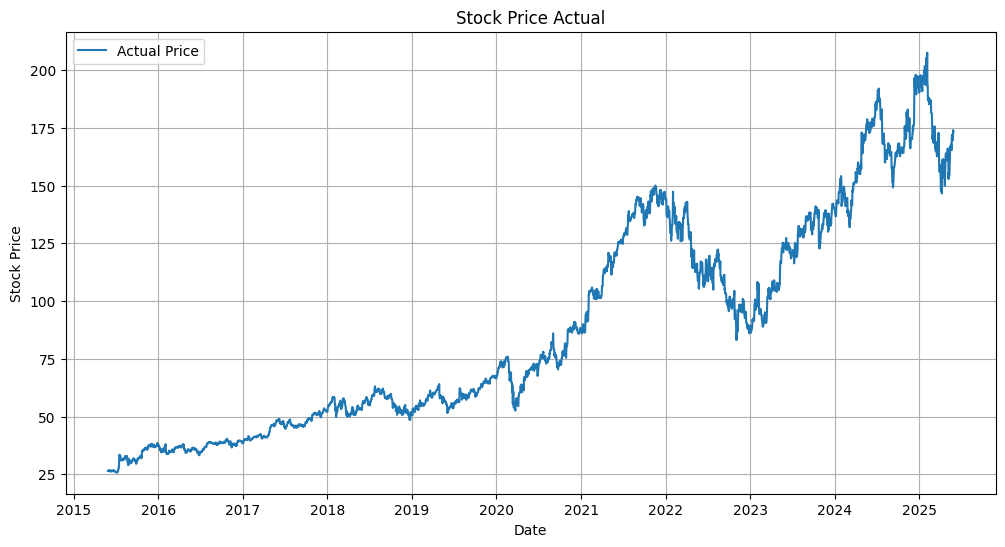

In [52]:
# Vẽ đồ thị giá thực
dates = data.index[:]
plt.figure(figsize=(12, 6))
plt.plot(dates, close_prices, label='Actual Price')
plt.title('Stock Price Actual')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()


In [77]:
# Step 3.2: Build LSTM model using library
def build_model(input_shape, units=50):
    model = Sequential() # giúp xếp các lớp
    model.add(LSTM(units, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

In [78]:
# Prepare data
def create_dataset(data, window_size=60): # kích thước của sổ mặc định(nếu không truyền vào thì window_size=60)
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(data[i])
    return np.array(X), np.array(y)

In [ ]:
# Lấy dữ liệu gốc
close_prices = data['Close'].values.reshape(-1, 1)
total_len = len(close_prices)

# Chia theo 80% train, 10% val, 10% test
train_end = int(0.8 * total_len)
val_end = int(0.9 * total_len)

# ⚠️ Giữ lại 90 ngày trước khi chia để đủ cho mọi window_size
max_window_size = 90
train_raw = close_prices[:train_end]
val_raw = close_prices[train_end - max_window_size:val_end]
test_raw = close_prices[val_end - max_window_size:]

# Chuẩn hóa
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_raw)
val_scaled = scaler.transform(val_raw)
test_scaled = scaler.transform(test_raw)


In [ ]:
def particle_swarm_optimization(population_size=10, max_generations=30,patience=5, target_mse=0.001, no_improve_count=0, w_max=0.9, w_min = 0.4):
    # 1. Tạo cá thể ngẫu nhiên (tọa độ và vận tốc)
    def create_particle():
        position = {
            'window_size': random.randint(30, 90),
            'units': random.choice([32, 64, 128])
        }
        velocity = {
            'window_size': random.uniform(-10, 10),
            'units': random.choice([-32, 0, 32])
        }
        return {
            'position': position,
            'velocity': velocity,
            'best_position': position.copy(),
            'best_score': float('inf')
        }

    # 2. Tính fitness
    def fitness(ind):
        window_size = int(round(ind['position']['window_size']))
        units = int(ind['position']['units'])

        # Giới hạn window_size nằm trong [30, 90] và units nằm trong {32, 64, 128}
        window_size = min(90, max(30, window_size))
        units = min([32, 64, 128], key=lambda x: abs(x - units))

        # Tạo dataset từ tập đã chia & chuẩn hóa
        X_train, y_train = create_dataset(train_scaled, window_size)
        X_val, y_val = create_dataset(val_scaled, window_size)

        model = build_model((window_size, 1), units=units)
        model.fit(X_train, y_train, epochs=3, batch_size=32, verbose=0)
        preds = model.predict(X_val)

        mse = mean_squared_error(y_val, preds)
        return mse, window_size, units

    # 3. Khởi tạo quần thể
    swarm = [create_particle() for _ in range(population_size)]
    global_best_position = None
    global_best_score = float('inf')
    best_score_history = float('inf')

    for gen in range(max_generations):
        print(f"\nLoop {gen+1}")
        w = w_max - (w_max - w_min) * gen / max_generations
        c1 = 2.5 - 2 * (gen / max_generations)
        c2 = 0.5 + 2 * (gen / max_generations)
        for i, particle in enumerate(swarm):
            score, actual_ws, actual_units = fitness(particle)
            print(f"Particle {i+1}: window_size={actual_ws}, units={actual_units}, MSE={score:.6f}")

            if score < particle['best_score']:
                particle['best_score'] = score
                particle['best_position'] = particle['position'].copy()

            if score < global_best_score:
                global_best_score = score
                global_best_position = particle['position'].copy()

        # 4. Cập nhật vận tốc và vị trí
        for particle in swarm:
            for key in ['window_size', 'units']:
                r1 = random.random()
                r2 = random.random()
                cognitive = c1 * r1 * (particle['best_position'][key] - particle['position'][key])
                social = c2 * r2 * (global_best_position[key] - particle['position'][key])
                particle['velocity'][key] = w * particle['velocity'][key] + cognitive + social
                #particle['position'][key] += particle['velocity'][key]

                # 👉 Velocity Clamping (Giới hạn vận tốc)
                #v_max = {'window_size': 10, 'units': 32}
                #particle['velocity'][key] = max(-v_max[key], min(v_max[key], particle['velocity'][key]))

                particle['position'][key] += particle['velocity'][key]
                # Giới hạn window_size và units
                if key == 'window_size':
                    particle['position'][key] = min(90, max(30, particle['position'][key]))
                elif key == 'units':
                    # Chỉ cho phép gần các giá trị 32, 64, 128
                    raw_units = particle['position'][key]
                    particle['position'][key] = min([32, 64, 128], key=lambda x: abs(x - raw_units))
                    
        print(f"Best individual of loop {gen+1}: window_size={int(global_best_position['window_size'])}, units={int(global_best_position['units'])}, MSE={global_best_score:.6f}")

         # 🔸 Điều kiện dừng sớm
        if global_best_score < best_score_history:
            best_score_history = global_best_score
            no_improve_count = 0
        else:
            no_improve_count += 1

        if global_best_score <= target_mse:
            print(f"Early stopping: đạt MSE mục tiêu {target_mse} ở thế hệ {gen+1}.")
            break
        if no_improve_count >= patience:
            print(f"Early stopping: không cải thiện trong {patience} thế hệ.")
            break

    # Trả về kết quả tốt nhất
    final_window_size = int(round(global_best_position['window_size']))
    final_units = int(global_best_position['units'])
    print(f"\nFinal best individual: window_size={final_window_size}, units={final_units}, MSE={global_best_score:.6f}")
    return {'window_size': final_window_size, 'units': final_units}

In [81]:
    # GA optimization
best_params = particle_swarm_optimization()
print("Best Parameters from PSO:", best_params)


Generation 1
12/12 [==============================] - 1s 10ms/step
Particle 1: window_size=77, units=128, MSE=0.001669
12/12 [==============================] - 1s 10ms/step
Particle 2: window_size=71, units=128, MSE=0.007983
13/13 [==============================] - 2s 60ms/step
Particle 3: window_size=67, units=128, MSE=0.006394
13/13 [==============================] - 2s 42ms/step
Particle 4: window_size=50, units=64, MSE=0.001108
13/13 [==============================] - 3s 46ms/step
Particle 5: window_size=46, units=64, MSE=0.001251
13/13 [==============================] - 1s 10ms/step
Particle 6: window_size=68, units=128, MSE=0.001171
12/12 [==============================] - 2s 50ms/step
Particle 7: window_size=80, units=128, MSE=0.001027
12/12 [==============================] - 2s 48ms/step
Particle 8: window_size=83, units=32, MSE=0.001576
13/13 [==============================] - 4s 48ms/step
Particle 9: window_size=50, units=32, MSE=0.001638
13/13 [=============================

In [82]:
from keras.callbacks import EarlyStopping

# 1. Lấy dữ liệu gốc (chưa chuẩn hóa)
close_prices = data['Close'].values.reshape(-1, 1)

# 2. Chia dữ liệu theo tỉ lệ 80% train, 10% val, 10% test
total_len = len(close_prices)
train_end = int(total_len * 0.8)
val_end = int(total_len * 0.9)

train_prices = close_prices[:train_end]
val_prices = close_prices[train_end - best_params['window_size']:val_end]
test_prices = close_prices[val_end - best_params['window_size']:]  # giữ lại window_size ngày

# 3. Fit scaler trên tập train và transform cả 3 phần
scaler = StandardScaler()
scaled_train = scaler.fit_transform(train_prices)
scaled_val = scaler.transform(val_prices)
scaled_test = scaler.transform(test_prices)

# 4. Tạo dataset
X_train, y_train = create_dataset(scaled_train, best_params['window_size'])
X_val, y_val = create_dataset(scaled_val, best_params['window_size'])
X_test, y_test = create_dataset(scaled_test, best_params['window_size'])

# 5. Gộp train + val để train mô hình cuối cùng
X_final_train = np.concatenate([X_train, X_val])
y_final_train = np.concatenate([y_train, y_val])

# 6. Xây mô hình
model = build_model((best_params['window_size'], 1), best_params['units'])

# 7. EarlyStopping (monitor trên `loss` vì không có val)
early_stop = EarlyStopping(
    monitor='loss',
    patience=5,
    restore_best_weights=True
)

# 8. Huấn luyện trên train + val
model.fit(
    X_final_train, y_final_train,
    epochs=100,
    batch_size=32,
    verbose=1,
    callbacks=[early_stop]
)

# 9. Dự đoán trên test set và tính RMSE
preds = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("✅ Test RMSE:", rmse)

Epoch 1/100
101/101 [==============================] - 8s 28ms/step - loss: 0.0500
Epoch 2/100
101/101 [==============================] - 2s 24ms/step - loss: 0.0167
Epoch 3/100
101/101 [==============================] - 2s 24ms/step - loss: 0.0151
Epoch 4/100
101/101 [==============================] - 2s 25ms/step - loss: 0.0151
Epoch 5/100
101/101 [==============================] - 3s 25ms/step - loss: 0.0137
Epoch 6/100
101/101 [==============================] - 2s 24ms/step - loss: 0.0146
Epoch 7/100
101/101 [==============================] - 2s 24ms/step - loss: 0.0118
Epoch 8/100
101/101 [==============================] - 2s 24ms/step - loss: 0.0119
Epoch 9/100
101/101 [==============================] - 2s 24ms/step - loss: 0.0116
Epoch 10/100
101/101 [==============================] - 2s 24ms/step - loss: 0.0112
Epoch 11/100
101/101 [==============================] - 2s 24ms/step - loss: 0.0112
Epoch 12/100
101/101 [==============================] - 3s 25ms/step - loss: 0.0121
E

12/12 [==============================] - 0s 10ms/step


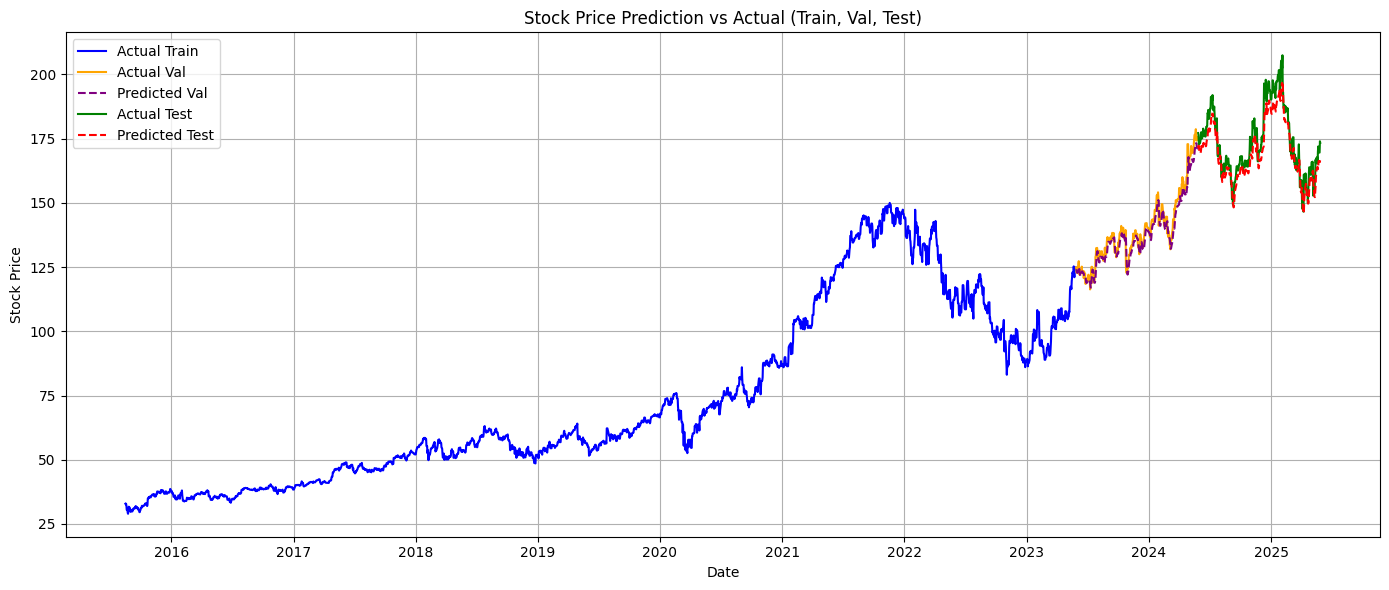

In [83]:
# Dự đoán từng phần
train_preds = model.predict(X_train)
val_preds = model.predict(X_val)
test_preds = model.predict(X_test)

# Inverse transform các phần
y_train_rescaled = scaler.inverse_transform(y_train)
train_preds_rescaled = scaler.inverse_transform(train_preds)

y_val_rescaled = scaler.inverse_transform(y_val)
val_preds_rescaled = scaler.inverse_transform(val_preds)

y_test_rescaled = scaler.inverse_transform(y_test)
test_preds_rescaled = scaler.inverse_transform(test_preds)

# Lấy index ngày tương ứng
train_start = best_params['window_size']
val_start = train_end
test_start = val_end

train_dates = data.index[train_start:train_start + len(y_train)]
val_dates = data.index[val_start:val_start + len(y_val)]
test_dates = data.index[test_start:test_start + len(y_test)]

# Vẽ biểu đồ chung
plt.figure(figsize=(14, 6))
plt.plot(train_dates, y_train_rescaled, label='Actual Train', color='blue')
#plt.plot(train_dates, train_preds_rescaled, label='Predicted Train', color='black', linestyle='--')

plt.plot(val_dates, y_val_rescaled, label='Actual Val', color='orange')
plt.plot(val_dates, val_preds_rescaled, label='Predicted Val', color='purple', linestyle='--')

plt.plot(test_dates, y_test_rescaled, label='Actual Test', color='green')
plt.plot(test_dates, test_preds_rescaled, label='Predicted Test', color='red', linestyle='--')

plt.title('Stock Price Prediction vs Actual (Train, Val, Test)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


12/12 [==============================] - 0s 31ms/step
Độ sai số trung bình trên tập validation: 2.5271805436643837 dolar


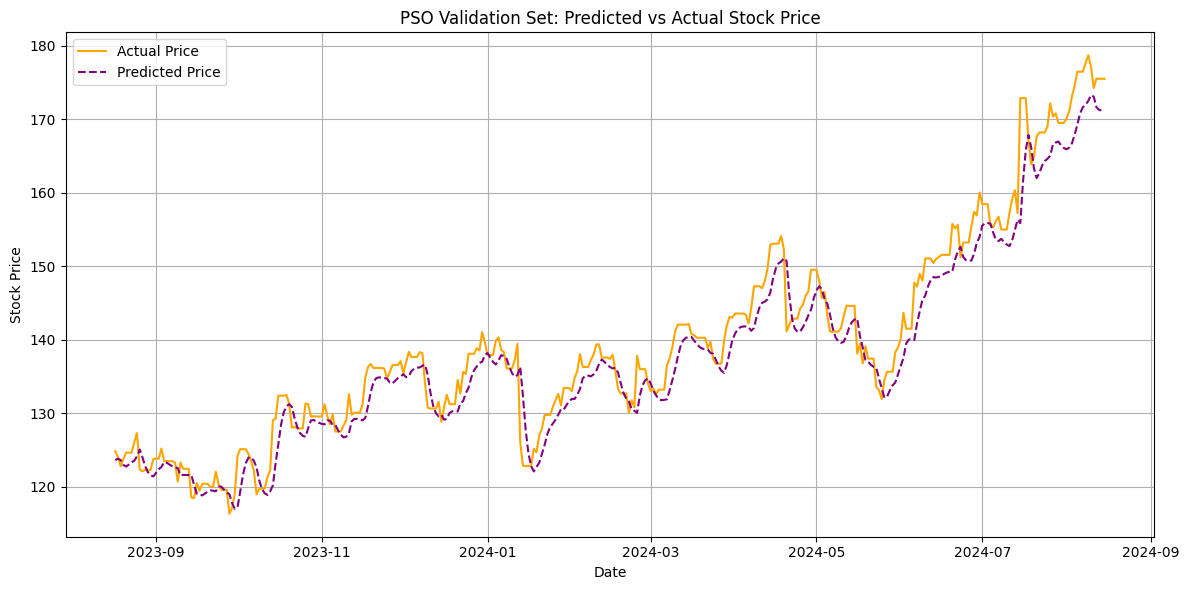

In [84]:
# Dự đoán trên tập validation
val_preds = model.predict(X_val)

# Inverse transform y_val và dự đoán
y_val_rescaled = scaler.inverse_transform(y_val)
val_preds_rescaled = scaler.inverse_transform(val_preds)

# MAE trên tập validation
val_mae = np.mean(np.abs(y_val_rescaled - val_preds_rescaled))
print("Độ sai số trung bình trên tập validation:", val_mae, "dolar")

# Lấy index ngày đúng cho tập validation
val_start_index = train_end + best_params['window_size']
val_dates = data.index[val_start_index : val_start_index + len(y_val)]

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.plot(val_dates, y_val_rescaled, label='Actual Price', color='orange')
plt.plot(val_dates, val_preds_rescaled, label='Predicted Price', color='purple', linestyle='--')
plt.title('PSO Validation Set: Predicted vs Actual Stock Price')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Độ sai số trung bình trên tập test: 4.631474604372118 dolar
MAPE trên tập test: 2.62%


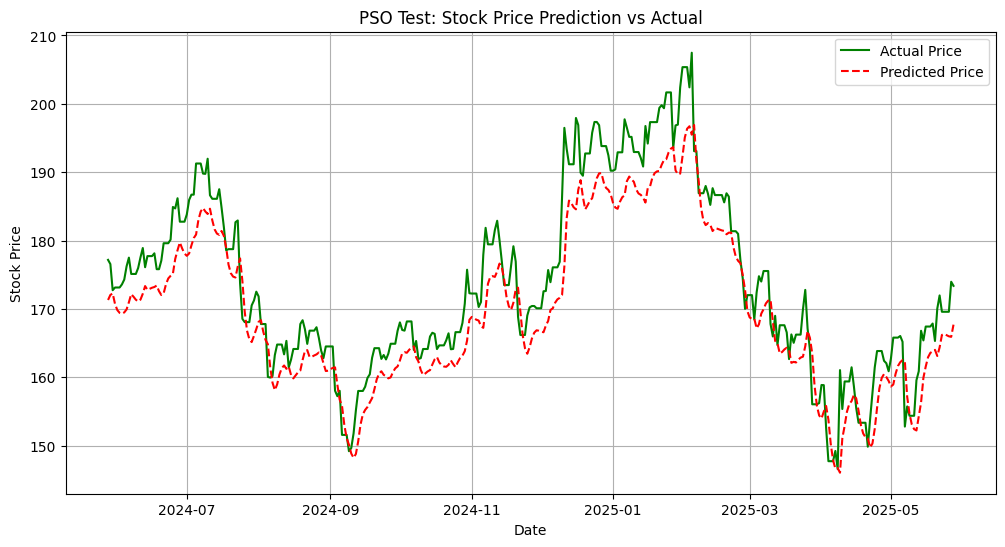

In [85]:
# Plot predictions vs actual
y_test_rescaled = scaler.inverse_transform(y_test)
preds_rescaled = scaler.inverse_transform(preds)
mae = np.mean(np.abs(y_test_rescaled- preds_rescaled))
print("Độ sai số trung bình trên tập test:", mae, "dolar")
mape = np.mean(np.abs((y_test_rescaled - preds_rescaled) / y_test_rescaled)) * 100 # Tỷ lệ phần trăm sai số trung bình
print(f"MAPE trên tập test: {mape:.2f}%")
# Get the corresponding dates for the last 100 entries (the test set)
dates = data.index[-len(y_test):]  # data is the original DataFrame from yfinance
plt.figure(figsize=(12, 6))
plt.plot(dates, y_test_rescaled, label='Actual Price', color='green')
plt.plot(dates, preds_rescaled, label='Predicted Price', color='red', linestyle='--')
plt.title('PSO Test: Stock Price Prediction vs Actual')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()


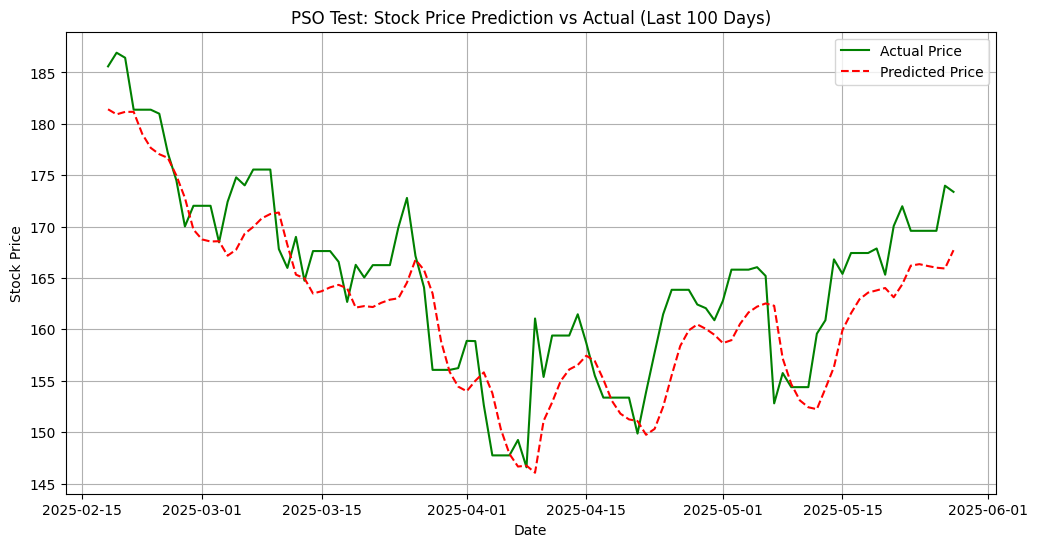

In [86]:
# Chỉ lấy 100 mẫu cuối cùng
num_plot = 100
y_test_subset = y_test[-num_plot:]
preds_subset = preds[-num_plot:]

# Biến đổi ngược lại giá gốc
y_test_rescaled = scaler.inverse_transform(y_test_subset)
preds_rescaled = scaler.inverse_transform(preds_subset)

# Lấy đúng 100 ngày cuối tương ứng trong dữ liệu gốc
dates = data.index[-num_plot:]

# Vẽ đồ thị
plt.figure(figsize=(12, 6))
plt.plot(dates, y_test_rescaled, label='Actual Price', color='green')
plt.plot(dates, preds_rescaled, label='Predicted Price', color='red', linestyle='--')
plt.title('PSO Test: Stock Price Prediction vs Actual (Last 100 Days)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()
